In [ ]:
!rm -rf spark-3.1.1-bin-hadoop3.2

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled", True) 

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [ ]:
!pip show pyspark

Name: pyspark
Version: 3.4.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 


In [ ]:
import datetime as dt
import yfinance as yfc
import pandas as pd
import numpy as np

company = 'JPM'
start_date = dt.datetime(2005,1,1)
end_date =  dt.datetime(2020,4,1)

data_yfc = yfc.download(company, start_date , end_date)
data_yfc.reset_index(inplace=True)
data_yfc['Date'] = pd.to_datetime(data_yfc['Date']).dt.date
stock_dt=spark.createDataFrame(data_yfc) 


stock_dt.show(10)

[*********************100%***********************]  1 of 1 completed
+----------+------------------+------------------+------------------+------------------+------------------+--------+
|      Date|              Open|              High|               Low|             Close|         Adj Close|  Volume|
+----------+------------------+------------------+------------------+------------------+------------------+--------+
|2005-01-03| 39.47999954223633|39.689998626708984|  39.0099983215332|39.150001525878906|23.722320556640625|14957900|
|2005-01-04| 38.97999954223633|39.060001373291016| 38.31999969482422| 38.40999984741211| 23.47782325744629|11360900|
|2005-01-05|38.599998474121094| 38.91999816894531| 38.38999938964844|  38.4900016784668| 23.52672576904297| 9770200|
|2005-01-06| 38.77000045776367| 38.97999954223633| 38.63999938964844|38.709999084472656|23.661190032958984| 9115900|
|2005-01-07|38.689998626708984|38.869998931884766| 38.38999938964844|38.400001525878906|23.471712112426758| 9971

In [ ]:
stock_dt.count()

3837

In [ ]:
stock_dt.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)



In [ ]:
jpm_close_dt = stock_dt.select('Close')

In [ ]:
jpm_close_dt.show(10)

+------------------+
|             Close|
+------------------+
|39.150001525878906|
| 38.40999984741211|
|  38.4900016784668|
|38.709999084472656|
|38.400001525878906|
| 38.27000045776367|
|37.900001525878906|
|  37.9900016784668|
| 37.77000045776367|
|37.810001373291016|
+------------------+
only showing top 10 rows



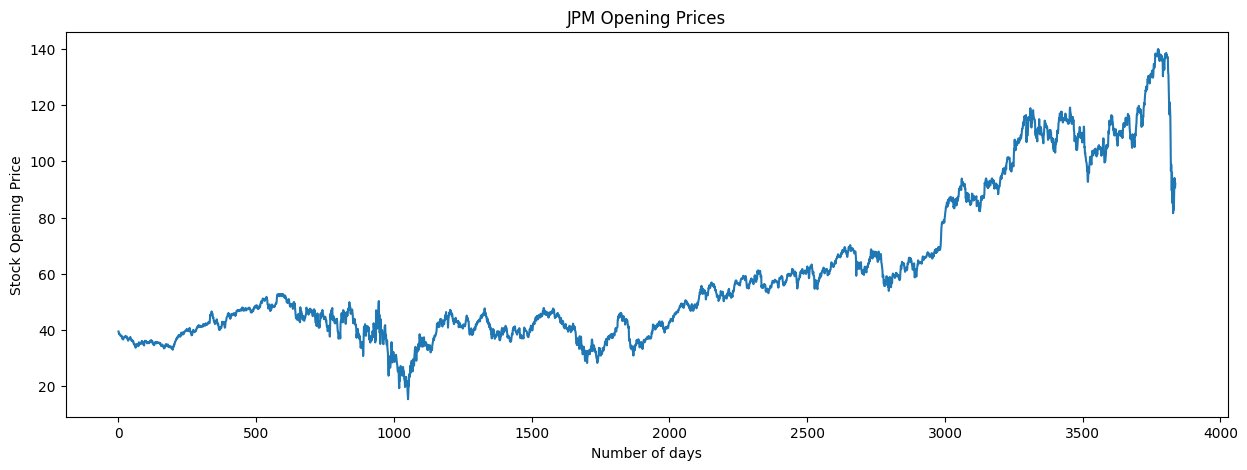

In [ ]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(figsize = (15,5))
ax.plot(stock_dt.select('Open').toPandas())
ax.set_title("JPM Opening Prices")
ax.set_xlabel("Number of days")
ax.set_ylabel("Stock Opening Price")
plt.show()

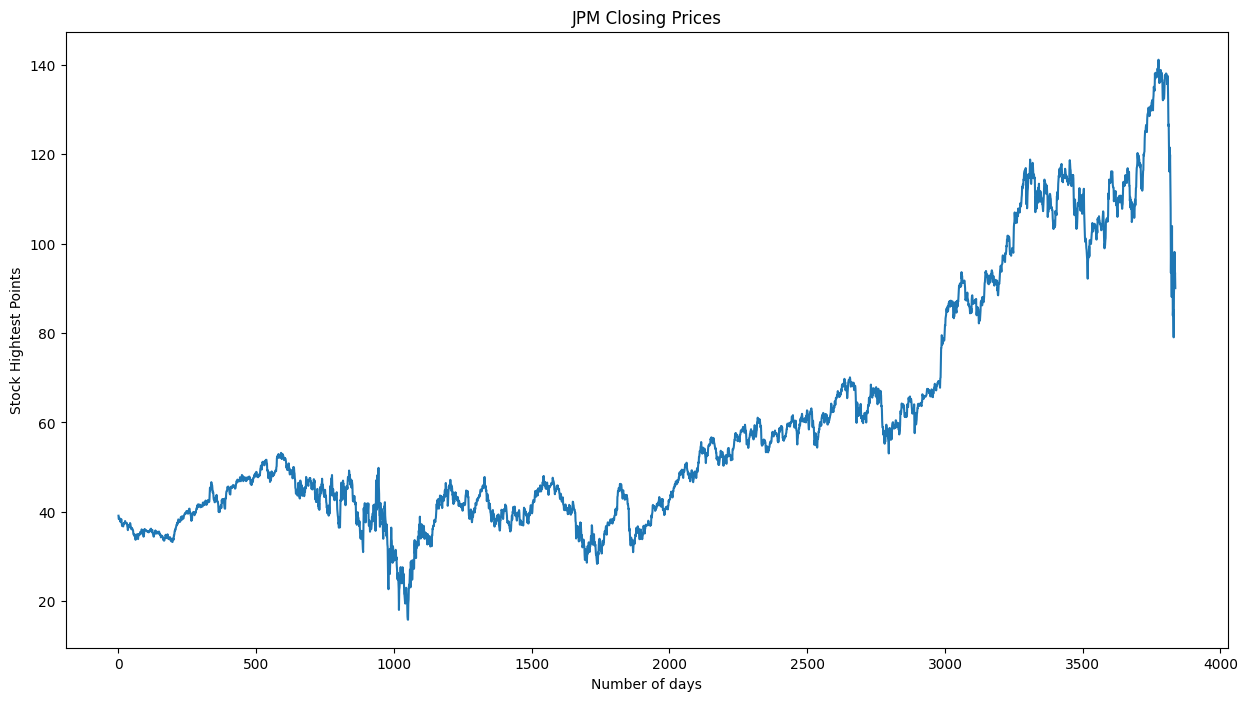

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(stock_dt.select('Close').toPandas())
plt.title("JPM Closing Prices")
plt.xlabel("Number of days")
plt.ylabel("Stock Hightest Points")
plt.show()

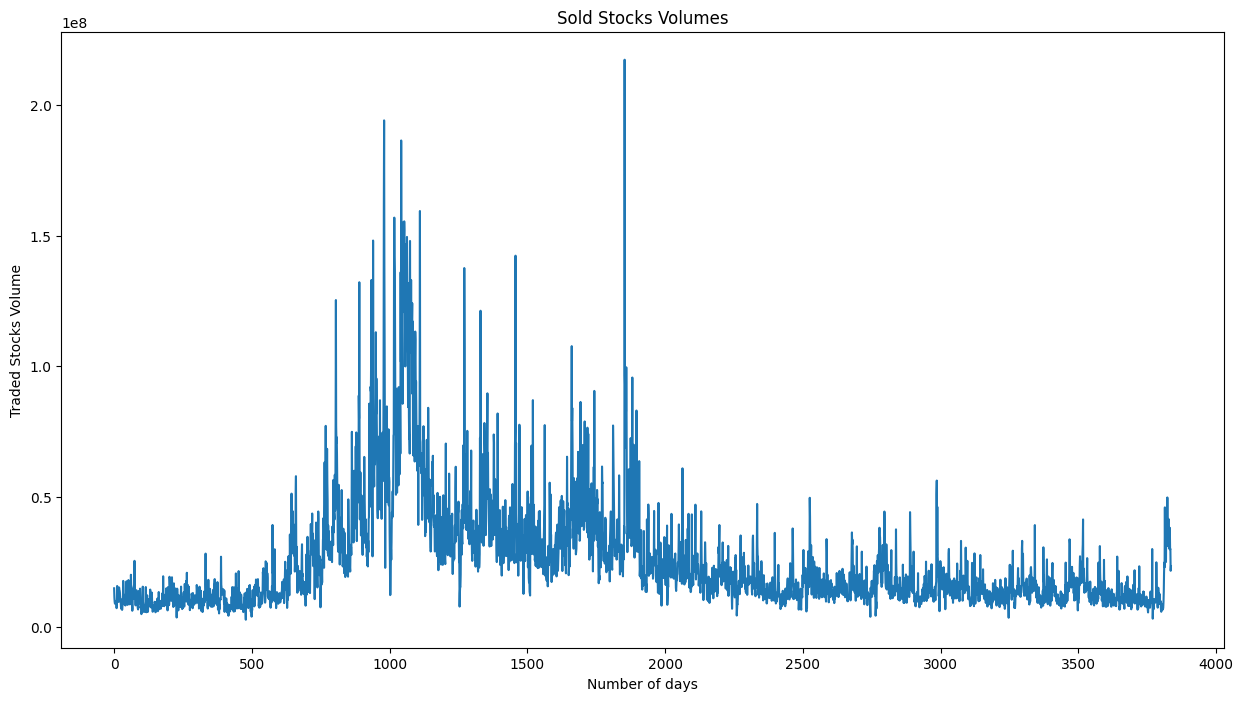

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(stock_dt.select('Volume').toPandas())
plt.title("Sold Stocks Volumes")
plt.xlabel("Number of days")
plt.ylabel("Traded Stocks Volume")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

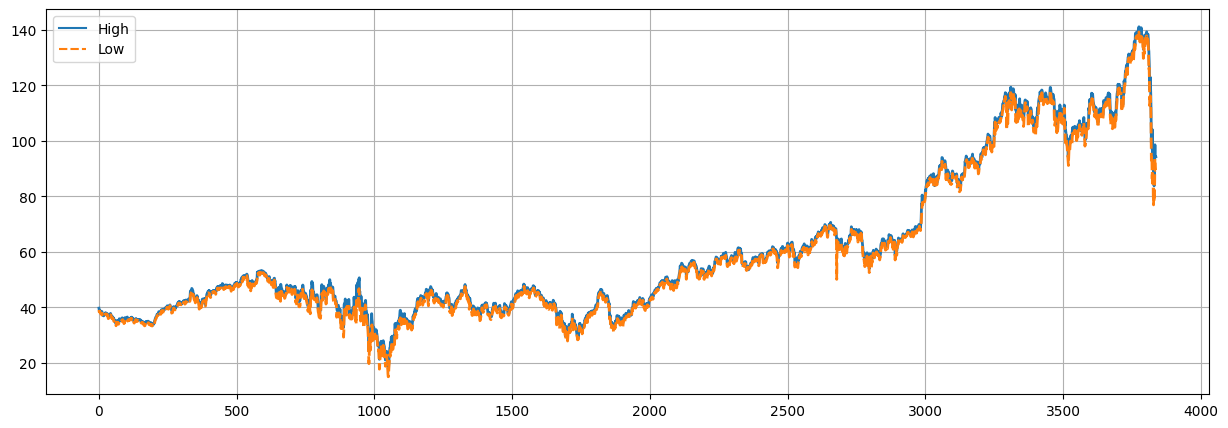

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.lineplot(data=stock_dt[['High','Low']].toPandas(),linewidth=2)
plt.grid(True)
plt.show

In [ ]:
stock_dt.toPandas().isnull().sum().any()

False

In [ ]:
# LSTM class
class LSTM:
    def __init__(self, inp_dim, hid_dim,input_seq_len, output_dim,reg_param):
      # Initialize weights and biases for LSTM
      self.wt_f = self.generate_random(hid_dim,inp_dim + hid_dim)
      self.bi_f = self.init_zeros((hid_dim, 1))
      self.wt_i = self.generate_random(hid_dim,inp_dim + hid_dim)
      self.bi_i = self.init_zeros((hid_dim,1))
      self.wt_c = self.generate_random(hid_dim,inp_dim + hid_dim)
      self.bi_c = self.init_zeros((hid_dim,1))
      self.wt_o = self.generate_random(hid_dim,inp_dim + hid_dim)
      self.bi_o = self.init_zeros((hid_dim,1))
      
      # Initialize weights and biases for output layer
      self.wt_y = self.generate_random(output_dim, hid_dim)
      self.bi_y = self.init_zeros((output_dim, 1))
    
      # Normalising the weights
      self.wt_f /= np.sqrt(np.sum(self.wt_f ** 2))
      self.wt_i /= np.sqrt(np.sum(self.wt_i ** 2))
      self.wt_c /= np.sqrt(np.sum(self.wt_c ** 2))
      self.wt_o /= np.sqrt(np.sum(self.wt_o ** 2))
      self.wt_y /= np.sqrt(np.sum(self.wt_y ** 2))
      
      # storing the forward gate values
      self.fg_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      self.ig_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      self.ctilde_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      self.og_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      self.cg_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      self.hg_t = [self.init_zeros((hid_dim,1)) for _ in range(input_seq_len)]
      
      #input seq length and learning rate
      self.input_seq_len = input_seq_len
      self.reg_param = reg_param
      self.hid_dim = hid_dim
    
    def generate_random(self, d1, d2):
      return np.random.randn(d1 , d2)
    
    def init_zeros(self,shape):
      return np.zeros(shape)

    def sigmoid(self,x):
      return 1 / (1 + np.exp(-x))

        
    def forward(self, x):
      # Concatenate input and previous hidden state
      for j in range(input_seq_len):
        concat = np.vstack((self.hg_t[j-1], x[j]))
        # Compute gates 
        f = self.sigmoid(np.dot(self.wt_f, concat) + self.bi_f)
        i = self.sigmoid(np.dot(self.wt_i, concat) + self.bi_i)
        c_tilde = np.tanh(np.dot(self.wt_c, concat) + self.bi_c)
        c_curr = f * self.cg_t[j-1] + i * c_tilde
        o = self.sigmoid(np.dot(self.wt_o, concat) + self.bi_o)
        h_curr = o * np.tanh(c_curr)

        #storing 
        self.fg_t[j] = f
        self.ig_t[j] = i
        self.ctilde_t[j] = i
        self.cg_t[j] = c_curr
        self.og_t[j] = o   
        self.hg_t[j] = h_curr 
      

      y_pred = np.dot(self.wt_y,self.hg_t[-1])+self.bi_y
      return y_pred
      
    def backward(self,x,e_delta):
      d_wy = e_delta * self.hg_t[-1].T
      d_by = e_delta

      delta_eh = [self.init_zeros((self.hid_dim,1)) for _ in range(self.input_seq_len+1)]

      for j in reversed(range(self.input_seq_len)):
        delta_eh[j] = np.dot(self.wt_y.T,e_delta) + delta_eh[j+1]
        gradient_o = delta_eh[j] * np.tanh(self.cg_t[j])
        gradient_c = delta_eh[j] * self.og_t[j] * (1- np.tanh(self.cg_t[j]) ** 2)
        gradient_g = delta_eh[j] * self.og_t[j] * (1- np.tanh(self.cg_t[j]) ** 2)
        gradient_f = delta_eh[j] * self.og_t[j] * (1- np.tanh(self.cg_t[j]) ** 2) * self.cg_t[j-1]
        gradient_i = delta_eh[j] * self.og_t[j] * (1- np.tanh(self.cg_t[j]) ** 2) * self.ctilde_t[j]

        gradient_bias_i= gradient_i * self.ig_t[j] * (1- self.ig_t[j])
        gradient_bias_o= gradient_o * self.og_t[j] * (1- self.og_t[j])
        gradient_bias_f= gradient_f * self.fg_t[j] * (1- self.fg_t[j])
        gradient_bias_g= gradient_g * self.ctilde_t[j] * (1- self.ctilde_t[j])

        gradient_weight_i = np.dot(gradient_bias_i, np.vstack((self.hg_t[j-1],x[j])).T)
        gradient_weight_o = np.dot(gradient_bias_o, np.vstack((self.hg_t[j-1],x[j])).T)
        gradient_weight_g = np.dot(gradient_bias_g, np.vstack((self.hg_t[j-1],x[j])).T)
        gradient_weight_f = np.dot(gradient_bias_f, np.vstack((self.hg_t[j-1],x[j])).T)
        
        self.wt_f = self.wt_f - self.reg_param * gradient_weight_f
        self.wt_o = self.wt_o - self.reg_param * gradient_weight_o
        self.wt_i = self.wt_i - self.reg_param * gradient_weight_i
        self.wt_c = self.wt_c - self.reg_param * gradient_weight_g

        self.bi_c = self.bi_c - self.reg_param * gradient_bias_g
        self.bi_i = self.bi_c - self.reg_param * gradient_bias_i
        self.bi_f = self.bi_c - self.reg_param * gradient_bias_f
        self.bi_o = self.bi_c - self.reg_param * gradient_bias_o

      self.wt_y -= self.reg_param * d_wy 
      self.bi_y -= self.reg_param * d_by



In [ ]:
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import MinMaxScaler
import numpy as np
from pyspark.sql.functions import col,udf
from pyspark.sql.types import DoubleType
# Function to create input and output sequences
def create_sequences(data, input_seq_len, output_seq_len):
    X, y = [], []
    data_list = data.select("close").rdd.flatMap(lambda x: x).collect()
    for i in range(len(data_list) - input_seq_len - output_seq_len):
        X.append(data_list[i:i + input_seq_len])
        y.append(data_list[i + input_seq_len:i + input_seq_len + output_seq_len])
    X_data = np.array(X)
    y_data = np.array(y)
    return X_data, y_data

# normalize data
def normalize_data(jpm_close_dt):
    jpm_vc_asmb = VectorAssembler().setInputCols(['Close']).setOutputCol("vc_close")
    jpm_close_vc = jpm_vc_asmb.transform(jpm_close_dt)
    mmScaler = MinMaxScaler(inputCol="vc_close", outputCol="close") 
    mmModel =  mmScaler.fit(jpm_close_vc)
    scaled_df = mmModel.transform(jpm_close_vc)
    # define a UDF to extract the scaled value from the vector column
    extract_value = udf(lambda x: float(x[0]), DoubleType())

    # add a new column with the scaled value to the dataframe
    scaled_df = scaled_df.withColumn("close", extract_value(col("close")))  
    return scaled_df.select('close') 
    

# split data
def data_split(input_dt, output_dt, train_ratio):
    s_ind = int(len(input_dt) * train_ratio)
    x_train = input_dt[:s_ind]
    y_train = output_dt[:s_ind]
    x_test = input_dt[s_ind:]
    y_test = output_dt[s_ind:]
    return x_train, y_train, x_test, y_test


In [ ]:
from pyspark.sql.functions import abs,col, sqrt,lit
from decimal import Decimal
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, IntegerType, ArrayType,DoubleType
from pyspark.sql import SparkSession
def createDataframe(y_pred,y_actual):
  # Create dataframe schema
  sc = spark.sparkContext
  y_p = sc.parallelize(y_pred).map(lambda x: float(x[0][0])).collect()
  y_a = sc.parallelize(y_actual).map(lambda x: float(x[0])).collect()
  schema = StructType([
    StructField("y_actual", DoubleType(), True),
    StructField("y_pred", DoubleType(), True)
])
  # Create dataframe from arrays
  df = spark.createDataFrame(zip(y_a, y_p),schema=schema)
  return df
def calculateError(y_df):
  # Calculate RMSE
  y_df = y_df.withColumn("y_actual", col("y_actual"))
  y_df = y_df.withColumn("y_pred", col("y_pred"))

  mse = y_df.select(pow(col("y_pred") - col("y_actual"), 2).alias('mse')).agg({"mse": "avg"}).collect()[0][0]
  rmse = math.sqrt(mse)
  mae = y_df.select(abs(col("y_actual") - col("y_pred")).alias("mae")).agg({"mae": "avg"}).collect()[0][0]

  return mse, rmse, mae

In [ ]:
# Load stock data and preprocess
input_seq_len = 20
output_seq_len = 1
train_ratio = 0.8
data_norm = normalize_data(jpm_close_dt)
data_norm.show(10,truncate=False)
input_data, output_data = create_sequences(data_norm, input_seq_len, output_seq_len)
x_train, y_train, x_test, y_test = data_split(input_data, output_data, train_ratio)



+-------------------+
|close              |
+-------------------+
|0.18571772918461202|
|0.17980670036554697|
|0.18044574368491081|
|0.18220305187063612|
|0.1797268351862578 |
|0.17868840502792285|
|0.17573290585402165|
|0.17645181435267465|
|0.17469447569568672|
|0.17501399735536863|
+-------------------+
only showing top 10 rows



In [ ]:
# Initialize LSTM model
import math
input_dim = input_seq_len
output_dim = output_seq_len
hidden_dim = 64
learning_rate = 0.01
lstm_model = LSTM(1, hidden_dim, input_dim, output_dim,learning_rate)

# Train LSTM model
num_epochs = 100

for epoch in range(num_epochs):
  y_pred = []

  for i in range(len(x_train)):
    y_t= lstm_model.forward(x_train[i])
    e_delta = 2*(y_t-y_train[i])
    lstm_model.backward(x_train[i],e_delta)
    y_pred.insert(i,y_t)

  if (epoch+1) % 10 == 0: 
    # calculate for every epoch, the Train error and loss
    df = createDataframe(y_pred,y_train.tolist())
    mse, rmse, mae = calculateError(df)
  
    print("Training MSE for epoch ",epoch,": ",mse)
    print("Training RMSE for epoch ",epoch,": ",rmse)
    print("Training MAE for epoch ",epoch,": ",mae)
    

Training MSE for epoch  9 :  0.00017248086472721968
Training RMSE for epoch  9 :  0.013133197048975535
Training MAE for epoch  9 :  0.007120929315822369
Training MSE for epoch  19 :  0.00014854921795903961
Training RMSE for epoch  19 :  0.012188076876974464
Training MAE for epoch  19 :  0.006805438642784097
Training MSE for epoch  29 :  0.00012247461917733228
Training RMSE for epoch  29 :  0.01106682516249951
Training MAE for epoch  29 :  0.006382672706373124
Training MSE for epoch  39 :  0.00010200166619131494
Training RMSE for epoch  39 :  0.010099587426787043
Training MAE for epoch  39 :  0.006022249353413417
Training MSE for epoch  49 :  8.870230484916981e-05
Training RMSE for epoch  49 :  0.009418190104747823
Training MAE for epoch  49 :  0.005788262969634829
Training MSE for epoch  59 :  8.090369405845667e-05
Training RMSE for epoch  59 :  0.00899464807863302
Training MAE for epoch  59 :  0.0056538376655933305
Training MSE for epoch  69 :  7.650992363477483e-05
Training RMSE for 

In [ ]:
mse = 0
y_tp = []
for i in range(len(x_train)):
  y_t= lstm_model.forward(x_train[i])
  y_tp.insert(i,y_t);
train_df = createDataframe(y_tp,y_train.tolist())
trn_mse,trn_rmse,trn_mae=calculateError(train_df)
print("Train Error Mean Squared Error",trn_mse)
print("Train Error Root Mean Squared Error",trn_rmse)
print("Train Error Mean Absolute Error",trn_mae)

Train Error Mean Squared Error 0.006552672080048929
Train Error Root Mean Squared Error 0.0809485767635783
Train Error Mean Absolute Error 0.07705073700050011


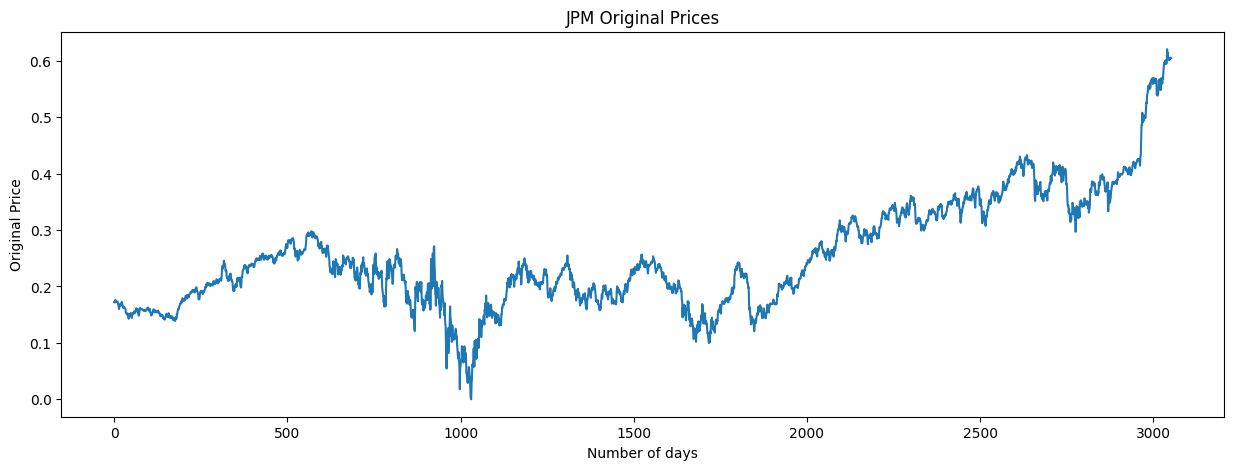

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_df.select('y_actual').toPandas())
plt.title("JPM Original Prices")
plt.xlabel("Number of days")
plt.ylabel("Original Price")
plt.show()

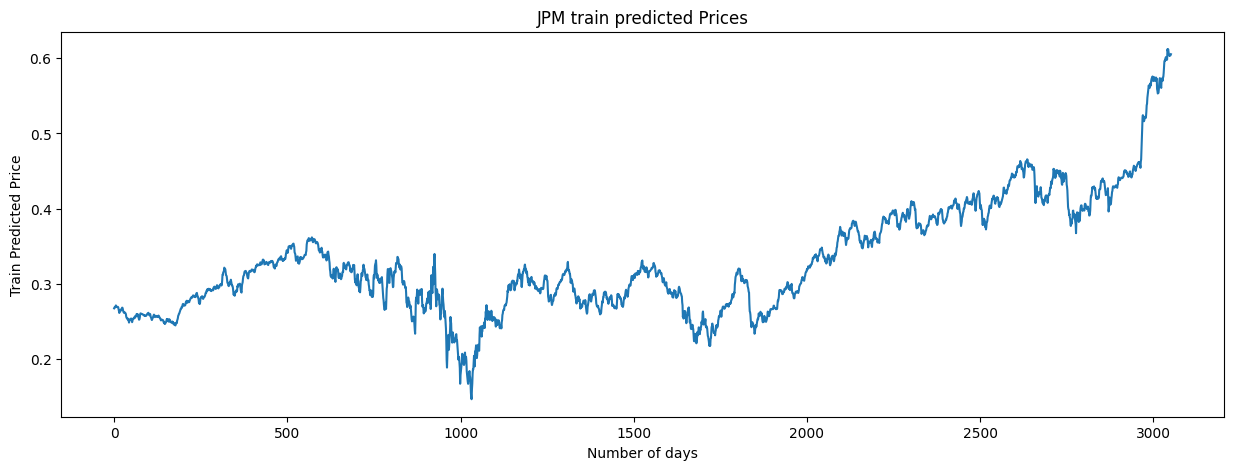

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_df.select('y_pred').toPandas())
plt.title("JPM train predicted Prices")
plt.xlabel("Number of days")
plt.ylabel("Train Predicted Price")
plt.show()

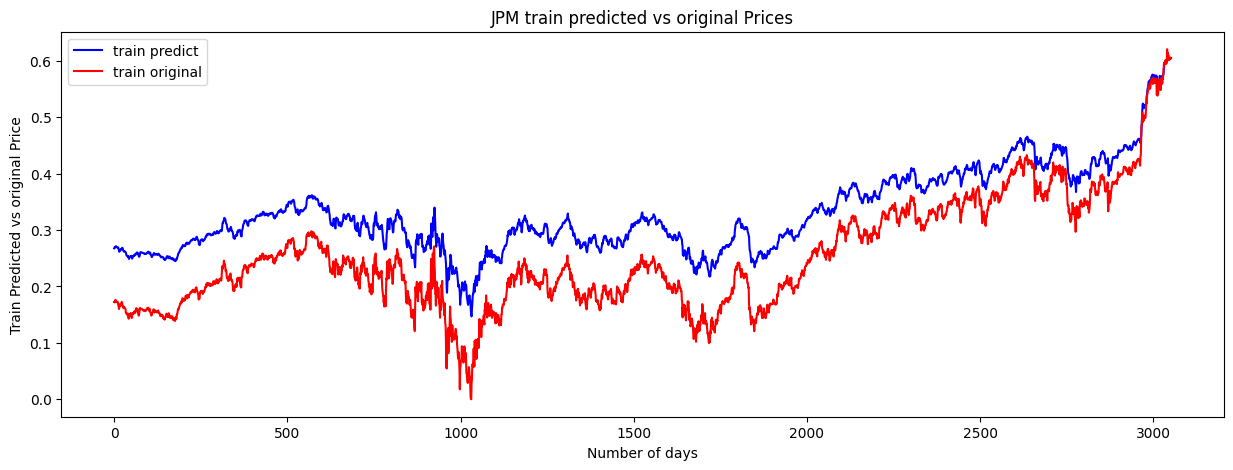

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_df.select('y_pred').toPandas(),color="blue",label="train predict")
plt.plot(train_df.select('y_actual').toPandas(),color="red",label="train original")
plt.title("JPM train predicted vs original Prices")
plt.xlabel("Number of days")
plt.ylabel("Train Predicted vs original Price")
plt.legend()
plt.show()

In [ ]:
# Evaluate LSTM model on test set
y_testP = []
for i in range(len(x_test)):
  y_t= lstm_model.forward(x_test[i])
  y_testP.insert(i,y_t);
test_df = createDataframe(y_testP,y_test.tolist())
tst_mse,tst_rmse,tst_mae=calculateError(test_df)
print("Test Error Mean Squared Error",tst_mse)
print("Test Error Root Mean Squared Error",tst_rmse)
print("Test Error Mean Absolute Error",tst_mae)

Test Error Mean Squared Error 0.0010172594754308225
Test Error Root Mean Squared Error 0.03189450541129024
Test Error Mean Absolute Error 0.026259985221136407


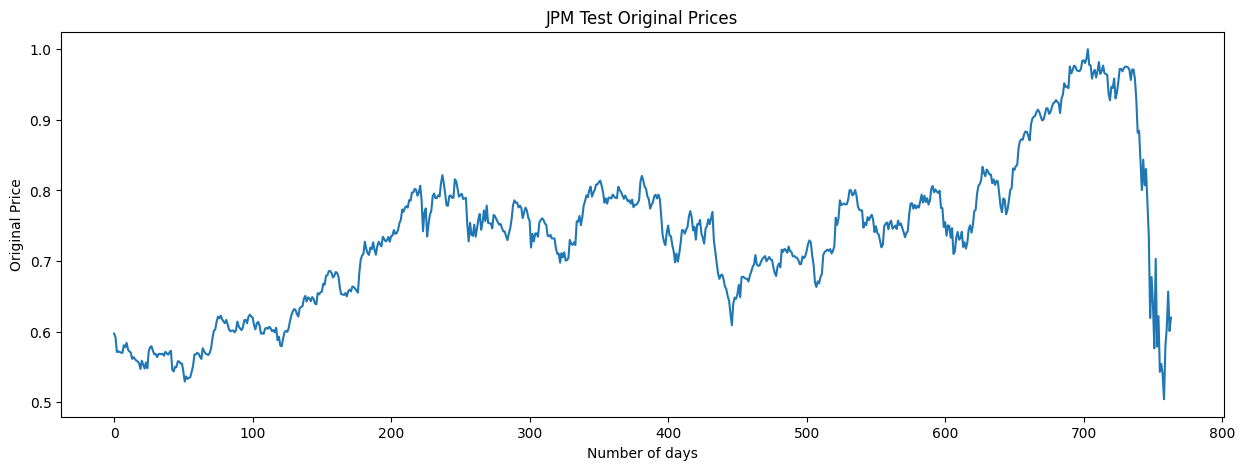

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_df.select('y_actual').toPandas())
plt.title("JPM Test Original Prices")
plt.xlabel("Number of days")
plt.ylabel("Original Price")
plt.show()

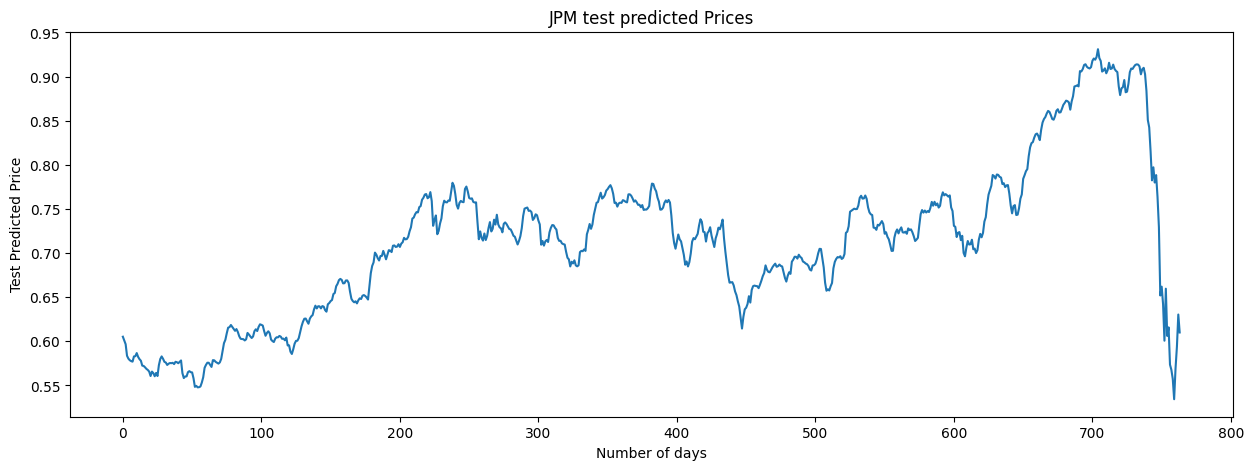

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_df.select('y_pred').toPandas())
plt.title("JPM test predicted Prices")
plt.xlabel("Number of days")
plt.ylabel("Test Predicted Price")
plt.show()

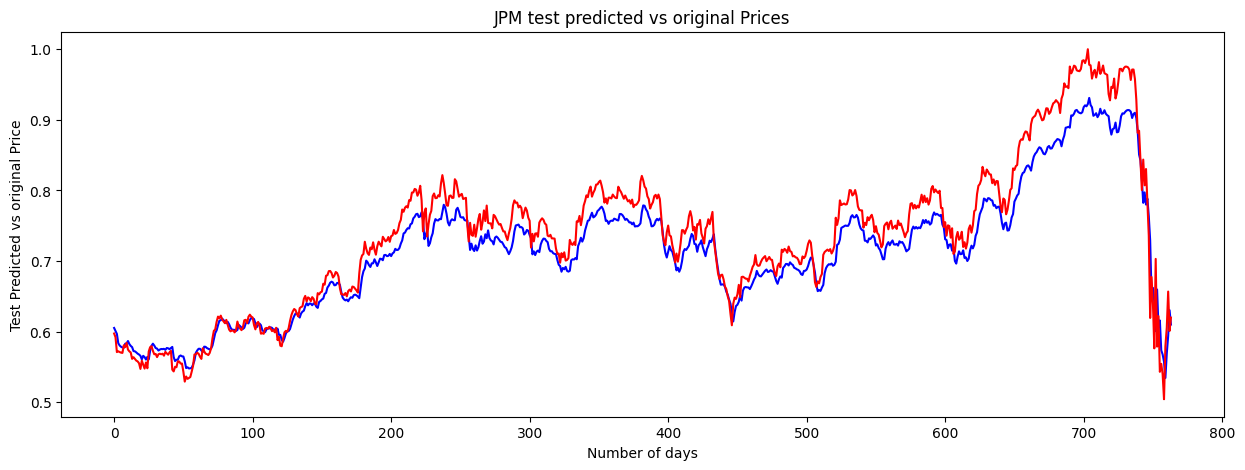

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_df.select('y_pred').toPandas(),color="blue",label="test predict")
plt.plot(test_df.select('y_actual').toPandas(),color="red",label="test original")
plt.title("JPM test predicted vs original Prices")
plt.xlabel("Number of days")
plt.ylabel("Test Predicted vs original Price")
plt.legend
plt.show()

In [ ]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
rfRegressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
rfRegressor.fit(x_train, y_train.reshape(-1))

RandomForestRegressor(random_state=0)

In [ ]:
# Lets Do the prediction 
train_predict=rfRegressor.predict(x_train).reshape(-1,1)
test_predict=rfRegressor.predict(x_test).reshape(-1,1)

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("------Train Data errors---------")
rfr_trnrmse = math.sqrt(mean_squared_error(y_train,train_predict))
rfr_trnmse = mean_squared_error(y_train,train_predict)
rfr_trnmae = mean_absolute_error(y_train,train_predict)
print("Train RMSE : ", rfr_trnrmse)
print("Train MSE: ", rfr_trnmse)
print("TRAIN MAE : ", rfr_trnmae)

print("--------Test Data Errors------------")
rfr_tstrmse = math.sqrt(mean_squared_error(y_test,test_predict))
rfr_tstmse = mean_squared_error(y_test,test_predict)
rfr_tstmae = mean_absolute_error(y_test,test_predict)
print("Test RMSE: ", rfr_tstrmse)
print("Test MSE: ", rfr_tstmse)
print("Test MAE: ", rfr_tstmae)

------Train Data errors---------
Train RMSE :  0.0030980975122947493
Train MSE:  9.598208195686916e-06
TRAIN MAE :  0.0020502608393703275
--------Test Data Errors------------
Test RMSE:  0.16722532931573897
Test MSE:  0.027964310764757343
Test MAE:  0.13658324578165204


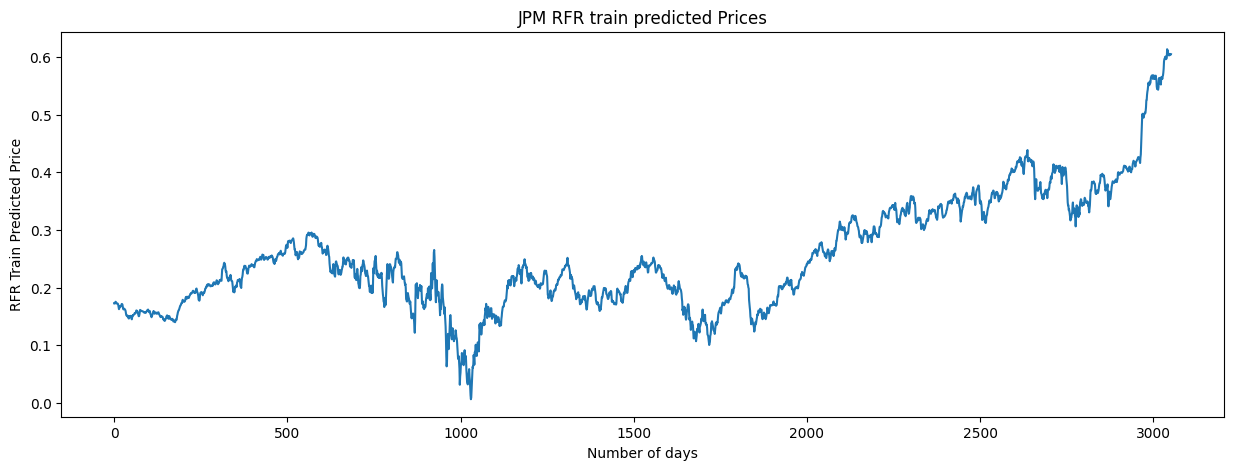

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_predict)
plt.title("JPM RFR train predicted Prices")
plt.xlabel("Number of days")
plt.ylabel("RFR Train Predicted Price")
plt.show()

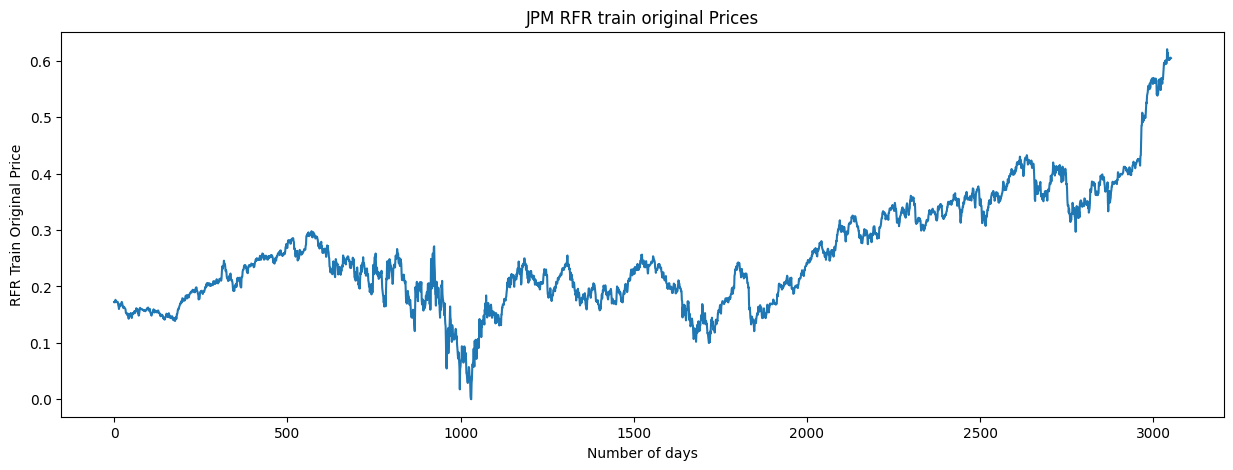

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_train)
plt.title("JPM RFR train original Prices")
plt.xlabel("Number of days")
plt.ylabel("RFR Train Original Price")
plt.show()

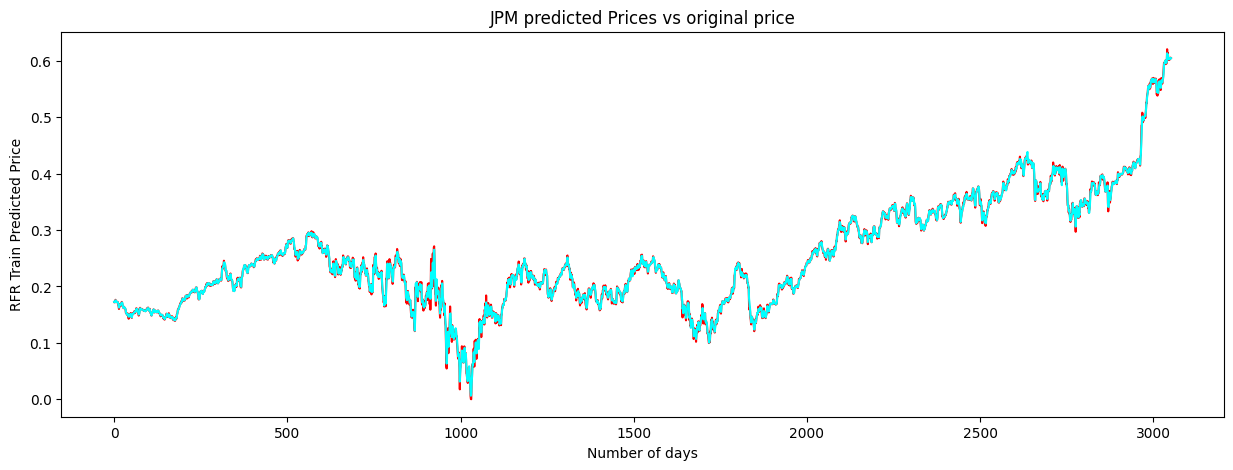

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_train,color='Red',label="train original")
plt.plot(train_predict,color='cyan',label="train predict")
plt.title("JPM predicted Prices vs original price")
plt.xlabel("Number of days")
plt.ylabel("RFR Train Predicted Price")
plt.show()

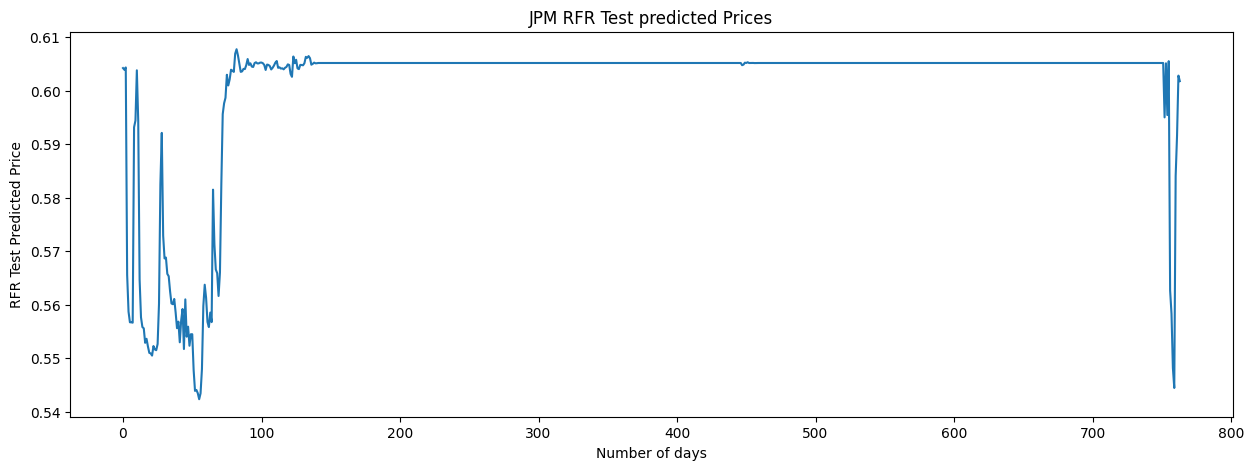

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_predict)
plt.title("JPM RFR Test predicted Prices")
plt.xlabel("Number of days")
plt.ylabel("RFR Test Predicted Price")
plt.show()

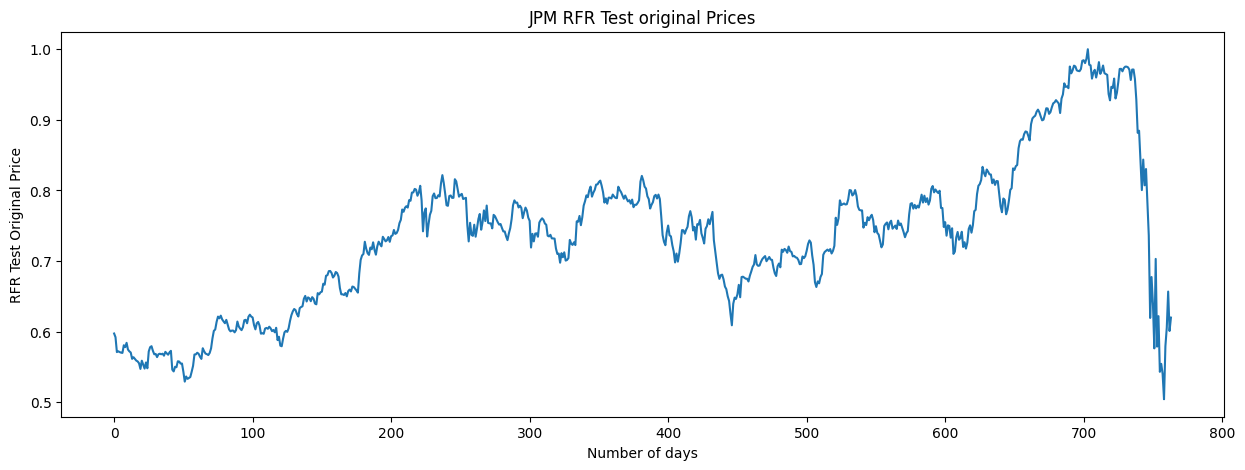

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test)
plt.title("JPM RFR Test original Prices")
plt.xlabel("Number of days")
plt.ylabel("RFR Test Original Price")
plt.show()

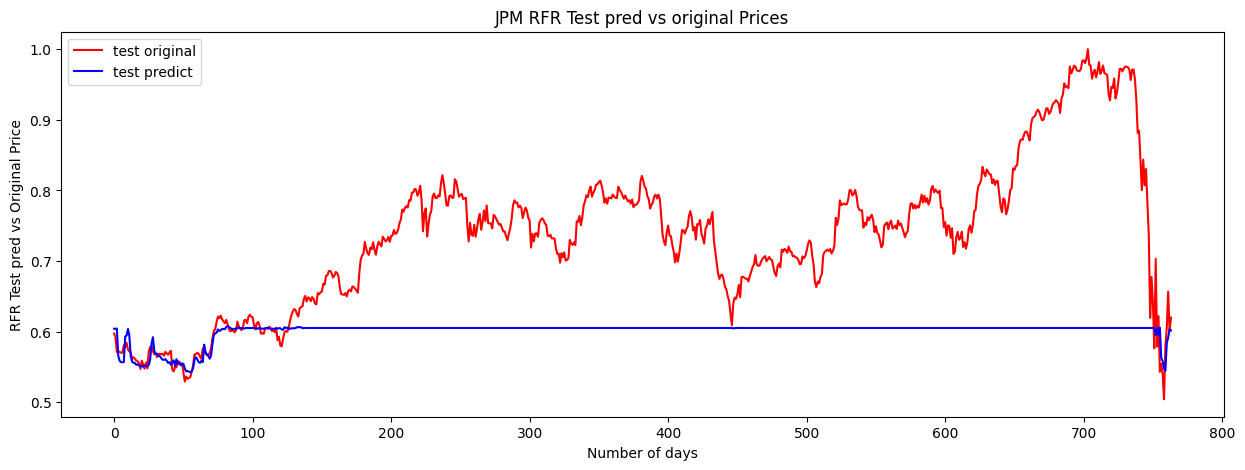

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test,color='Red',label="test original")
plt.plot(test_predict,color='blue',label="test predict")
plt.title("JPM RFR Test pred vs original Prices")
plt.xlabel("Number of days")
plt.ylabel("RFR Test pred vs Original Price")
plt.legend()
plt.show()